## Reproducing FaceForensics++: Learning to detect manipulated facial images

### Second Stage of Implemention (Data Pre-Processing)
#### Once the frames are extracted from the video sequences at this statge we pre-process the images and convert into a pickled files, then apply it in the model in the later stage.

To reproduce the same results, dataset extraction from the FaceForensics++ python script has to be requested using the form<br>link: https://docs.google.com/forms/d/e/1FAIpQLSdRRR3L5zAv6tQ_CKxmK4W96tAab_pfBu2EKAgQbeDVhmXagg/viewform<br>
Using the python script to extract dataset is the first stage of implementation.

Refereces: <br>
[1] https://github.com/ondyari/FaceForensics<br>
[2] https://medium.com/analytics-vidhya/detection-of-face-manipulated-videos-using-deep-learning-6bca870f3a6a<br>
[3] https://github.com/pothabattulasantosh/Detection-of-face-Manipulated-videos

Importing required libraries

In [1]:
import matplotlib.pyplot as plt #plotting library
import os #OS module to do os level operation such as mkdir,listsdir,..
from tqdm import tqdm_notebook as tqdm #To show the status bar for iterations
import numpy as np # To handle matrix operations
import cv2 # computer vision library
import dlib # Automatic face tracking library
face_detector = dlib.get_frontal_face_detector() # instantiating face detector class from dlib library 
from keras.applications.xception import preprocess_input # to preprocess the input
from keras import models
import joblib # To presist the intermideate files 
import warnings#
warnings.filterwarnings('ignore')# To ignore the unwanted warning messages

Creating bounding box (Expects a dlib face to generate a quadratic bounding box.)
#### Reference: https://github.com/ondyari/FaceForensics <br>

In [2]:
def get_boundingbox(face, width, height, scale=1.3, minsize=None):
    
    x1 = face.left() # Taking lines numbers around face
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()
    size_bb = int(max(x2 - x1, y2 - y1) * scale) # scaling size of box to 1.3
    if minsize:
        if size_bb < minsize:
            size_bb = minsize
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

    # Check for out of bounds, x-y top left corner
    x1 = max(int(center_x - size_bb // 2), 0)
    y1 = max(int(center_y - size_bb // 2), 0)
    # Check for too big bb size for given x, y
    size_bb = min(width - x1, size_bb)
    size_bb = min(height - y1, size_bb)

    return x1, y1, size_bb

Class Labelling assingning,tracking the face,drawing a box around the tracked face and putting the label and confidence values

In [3]:
def get_predicition(image):
    
    height, width = image.shape[:2]
    try: # If in case face is not detected at any frame
        face = face_detector(image, 1)[0]  # Face detection
        x, y, size = get_boundingbox(face=face, width=width, height=height) # Calling to get bound box around the face
    except IndexError:
        pass
    cropped_face = image[y:y+size, x:x+size] # cropping the face 
    output,label = evaluate(cropped_face) # Sending the cropped face to get classifier result 
    font_face = cv2.FONT_HERSHEY_SIMPLEX # font settings
    thickness = 2
    font_scale = 1
    if label=='Real':
        color = (0,255, 0)
    else:
        color = (0, 0, 255)
    x = face.left()    # Setting the bounding box on uncropped image
    y = face.top()
    w = face.right() - x
    h = face.bottom() - y
    cv2.putText(image, label+'_'+str('%.2f'%output)+'%', (x, y+h+30), 
            font_face, font_scale,
            color, thickness, 2) # Putting the label and confidence values

    return cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)# draw box over face

Setting Path

In [4]:
DATASET_PATHS = {
    'original': 'original_sequences',
    'Deepfakes': 'manipulated_sequences\Deepfakes',
    'Face2Face': 'manipulated_sequences\Face2Face',
    'FaceSwap': 'manipulated_sequences\FaceSwap'
}

Lets observe extracted images form each type

In [5]:
images = []
for path in DATASET_PATHS:
    for seq in os.listdir(DATASET_PATHS[path]+'/c23/images/')[:1]:
        for image in os.listdir(DATASET_PATHS[path]+'/c23/images/'+seq)[:1]:
            img = cv2.imread(DATASET_PATHS[path]+'/c23/images/'+seq+'/'+image)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append([img,path])

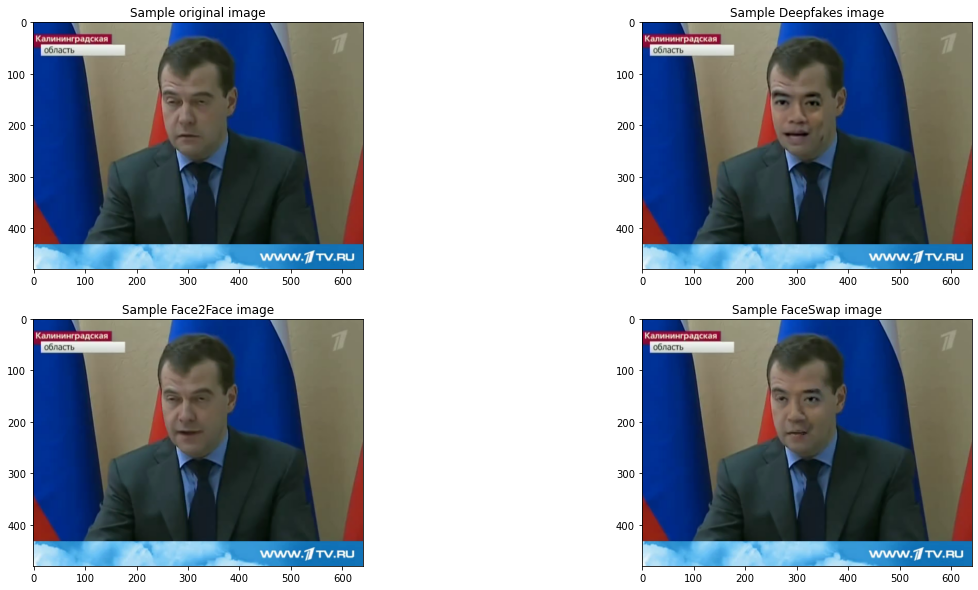

In [6]:
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(221+i)
    plt.title("Sample {} image".format(images[i][1]))
    plt.imshow(images[i][0])

We are only interested in face part, Hence tracking only faces in the images.

In [7]:
cropped_face =[]
for image in images:
    faces = face_detector(image[0], 1)
    height, width = image[0].shape[:2]
    try: # If in case face is not detected at any frame 
        x, y, size = get_boundingbox(face=faces[0], width=width, height=height)
    except IndexError:
        continue
    cropped_face.append([image[0][y:y+size, x:x+size],image[1]])

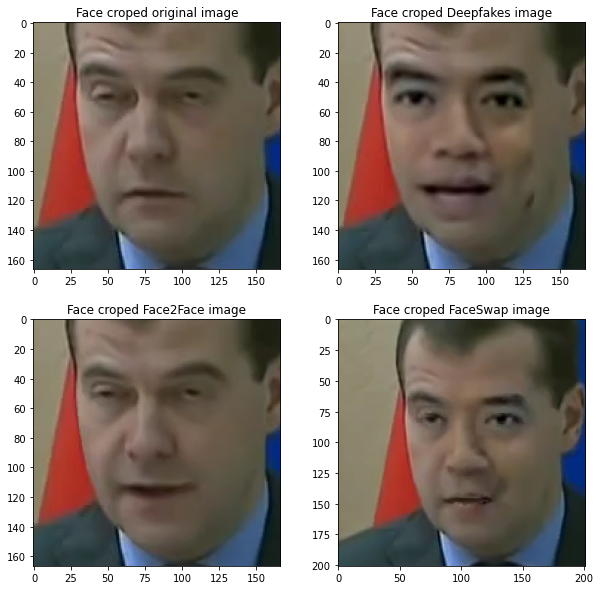

In [8]:
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(221+i)
    plt.title("Face croped {} image".format(cropped_face[i][1]))
    plt.imshow(cropped_face[i][0])

Now We repeat the same process for every image , before that lets split the data into Train, Cv, Test

Creating Train, Test, CV split lists

In [9]:
train_original = (os.listdir(DATASET_PATHS['original']+'/c23/images/'))[:30]
train_Deepfakes = (os.listdir(DATASET_PATHS['Deepfakes']+'/c23/images/'))[:10]
train_FaceSwap = (os.listdir(DATASET_PATHS['FaceSwap']+'/c23/images/'))[:10]
train_Face2Face = (os.listdir(DATASET_PATHS['Face2Face']+'/c23/images/'))[:10]
train = [train_original,train_Deepfakes,train_FaceSwap,train_Face2Face]
types = ['original','Deepfakes','FaceSwap','Face2Face']

In [10]:
cv_original = (os.listdir(DATASET_PATHS['original']+'/c23/images/'))[30:][:3]
cv_Deepfakes = (os.listdir(DATASET_PATHS['Deepfakes']+'/c23/images/'))[10:][:1]
cv_FaceSwap = (os.listdir(DATASET_PATHS['FaceSwap']+'/c23/images/'))[10:][:1]
cv_Face2Face = (os.listdir(DATASET_PATHS['Face2Face']+'/c23/images/'))[10:][:1]
cv = [cv_original,cv_Deepfakes,cv_FaceSwap,cv_Face2Face]

In [11]:
test_original = (os.listdir(DATASET_PATHS['original']+'/c23/images/'))[-18:-1]
test_Deepfakes = (os.listdir(DATASET_PATHS['Deepfakes']+'/c23/images/'))[-7:-1]
test_FaceSwap = (os.listdir(DATASET_PATHS['FaceSwap']+'/c23/images/'))[-6:-1]
test_Face2Face = (os.listdir(DATASET_PATHS['Face2Face']+'/c23/images/'))[-7:-1]
test = [test_original,test_Deepfakes,test_FaceSwap,test_Face2Face]

Repeating the same process splitted data and generated  similar face tracked images.<br>
* Expects a splited data list and generates face tracked images.
    

In [12]:
def track_face(split_type,Split,output_mkdir=True):
    
    for part in zip(split_type,types):
        for video in tqdm(part[0]):
            if output_mkdir==True:
                os.makedirs('Data/'+Split+'/'+part[1]+'/'+video, exist_ok=True)
            input_path = DATASET_PATHS[part[1]]+'/c23/images/'+video
            output_path = 'Data/'+Split+'/'+part[1]+'/'+video
            images = os.listdir(input_path)
            images.sort(key=lambda x: os.path.getmtime(input_path+'/'+x))
            for img in images[10:111]: #Taking 101  frames from each video
                image = cv2.imread(input_path+'/'+img)
                faces = face_detector(image, 1)
                height, width = image.shape[:2]
                try: # If in case face is not detected at any frame 
                    x, y, size = get_boundingbox(face=faces[0], width=width, height=height)
                except IndexError:
                    continue
                cropped_face = image[y:y+size, x:x+size]
                cv2.imwrite(output_path+'/'+img,cropped_face)     

In [13]:
track_face(split_type=train,Split='train')

In [14]:
track_face(split_type=test,Split='test')

In [15]:
track_face(split_type=cv,Split='cv')

### Checking some of the face tracked images in each split and category

In [16]:
def show_samples(split_name, category):
    """
    Expects a split type ("test"/"train"/"cv") and categoty (video type)
    and displays the 1st 20 face tracked images for a given
    split_name and category
    example : 
    show_samples(split_name="train", category="original")
    """
    category_ =[category]
    if split_name=='cv':
        videos= cv[types.index(category)][0]
    else:
        videos = [train[types.index(cat)] if split_name=='train' else test[types.index(cat)] for cat in category_][0][0] #used to be [0][2]
    plt.figure(figsize=(10,10))
    for video in [videos]:
        frames=os.listdir('Data/'+split_name+'/'+category+'/'+video) 
        j=0
        seq = os.listdir('Data/'+split_name+'/'+category+'/'+video)
        seq.sort(key=lambda x: os.path.getmtime('Data/'+split_name+'/'+category+'/'+video+'/'+x))
        for i,image in enumerate(seq):     
            if j==20:
                break
            plt.subplot(4,5,1+i)
            img = cv2.imread('Data/'+split_name+'/'+category+'/'+video+'/'+'/'+image)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            j = j+1
        break
    plt.show()

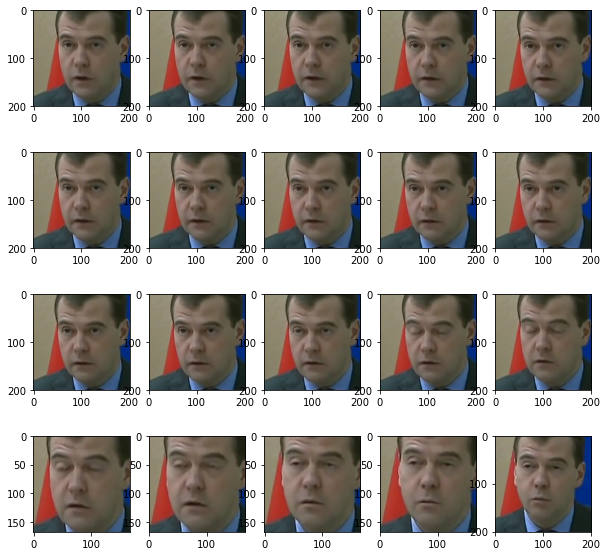

In [17]:
show_samples(split_name="train", category='original')

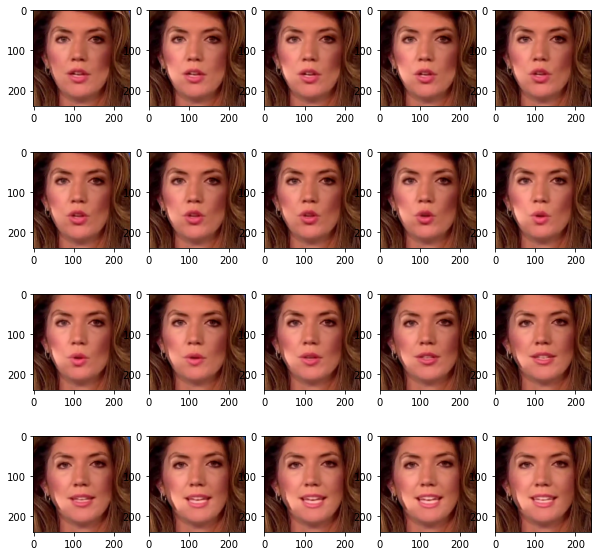

In [18]:
show_samples(split_name="cv", category='Deepfakes')

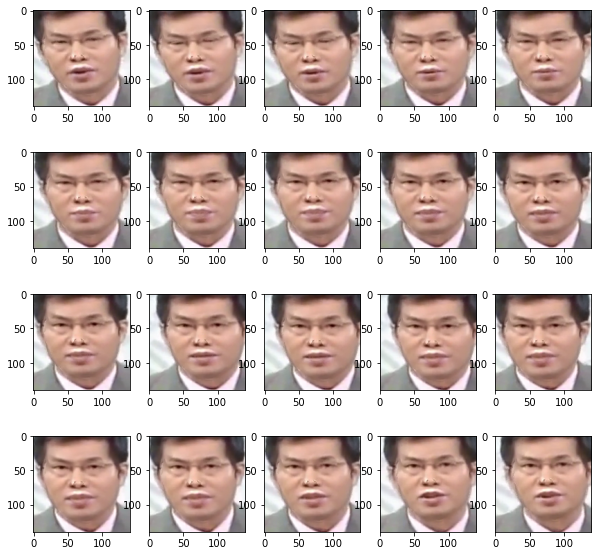

In [19]:
show_samples(split_name="test", category='Face2Face')

### Data Preprocessing and Storing
1. Shuffle the videos 
2. Read the face cropped images and resizing to 299X299
3. Assigning class label to every image 1 or 0 (Fake =1 and Real =0)
4. Preprocessing the data and pickiling

In [20]:
#Created to shuffle the videos
train_=[]
for ind,i in enumerate(train):
    for j in i:
        train_.append(j+'_'+types[ind])
test_=[]
for ind,i in enumerate(test):
    for j in i:
        test_.append(j+'_'+types[ind])
        
cv_=[]
for ind,i in enumerate(cv):
    for j in i:
        cv_.append(j+'_'+types[ind])

In [21]:
TRAIN_DATADIR = "Data/train"
TEST_DATADIR = "Data/test"
CV_DATADIR = 'Data/cv'
CLASSES = ["original", "Deepfakes","FaceSwap","Face2Face"]

In [22]:
def create_data(DATADIR,shuffled_list):
    """
    Expects Data Directory and suffled videos list
    and will returns list of image arrays and its class label (1 or 0)
    return X,y => image_arrays, class_labels
    """
    data = []
    for name in shuffled_list: 
        label = name.split('_')[-1] 
        class_num = 0
        folder_name = name.split('_')[0]
        #seq = os.listdir(DATADIR+'/'+name.split('_')[-1])
        if len(name.split('_'))==3:
            class_num=1
            folder_name = name.split('_')[0]+'_'+name.split('_')[1]
        files = os.listdir(DATADIR+'/'+label+'/'+folder_name)
        path = DATADIR+'/'+label+'/'+folder_name
        files.sort(key=lambda x: os.path.getmtime(DATADIR+'/'+label+'/'+folder_name+'/'+x))     
        for img in tqdm(files):           
            try:
                img_array = cv2.imread(os.path.join(path,img))
                img_array=cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (299, 299))
                data.append([new_array, class_num])
            except Exception as e:
                print(str(e))
            
    print("Data gathering completed......\n Separating features and class lables")
    X = []
    y = []
    for row in tqdm(data):
        X.append(row[0])
        y.append(row[1])
    X = np.array(X).reshape(-1, 299, 299, 3)
    print("Done")
    return X,y

In [23]:
np.random.shuffle(train_)
X_train,Y_train = create_data(DATADIR=TRAIN_DATADIR,
                        
                        shuffled_list=train_)


Data gathering completed......
 Separating features and class lables



Done


In [24]:
np.random.shuffle(test_)

X_test,Y_test = create_data(DATADIR=TEST_DATADIR, shuffled_list=test_)


Data gathering completed......
 Separating features and class lables



Done


In [25]:
X_cv,Y_cv = create_data(DATADIR=CV_DATADIR,
                        
                        shuffled_list=cv_)


Data gathering completed......
 Separating features and class lables



Done


In [26]:
X_train = preprocess_input(X_train)

In [27]:
X_cv = preprocess_input(X_cv)

In [28]:
X_test = preprocess_input(X_test)

In [29]:
joblib.dump(X_train, 'x_train.pkl')
joblib.dump(X_test, 'x_test.pkl')
joblib.dump(Y_test, 'y_test.pkl')
joblib.dump(Y_train, 'y_train.pkl')
joblib.dump(X_cv, 'x_cv.pkl')
joblib.dump(Y_cv, 'y_cv.pkl')

['y_cv.pkl']

In [30]:
x_test=joblib.load('x_test.pkl')


In [31]:
y_test=joblib.load('y_test.pkl')

In [32]:
from keras.utils import to_categorical,normalize
Y_test = to_categorical(y_test)


In [33]:
Y_test.shape

(3434, 2)

In [34]:
x_test.shape

(3434, 299, 299, 3)